# Deploying an STL Monitoring Service

In this notebook, we will show you how to deploy an STL monitoring service using `rtamt`.

This service will check whether the controller produced in [2-IncubatorControllerService.ipynb](../2-Controller-Modelling/2-IncubatorControllerService.ipynb) is working as intended. In particular, it will run periodically, and:
1. Queries the time series database influxdb to get a batch of data from the running PT emulator produced in [5-IncubatorPTEmulator](../5-IncubatorPTEmulator).
2. Evaluates an STL property on that specification.
3. Pushes the robustness of the specification back into influxdb.

In [ ]:
# Check pre-requisite scripts are available.

import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '8-Monitoring', 'Current directory is not 8-Monitoring'

# Get the parent directory absolute path. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# Check that the various scripts are available.

path_to_chek = os.path.join(parent_dir, '2-Controller-Modelling', 'controller.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '5-IncubatorPTEmulator', 'pt_emulator_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '6-PuttingItAllTogether', 'start_influxdb_rabbitmq.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

## Starting the Incubator

To run the services we will follow the same approach as in [6-PuttingItAllTogether](../6-PuttingItAllTogether/1-PuttingItAllTogether.ipynb): start multiple terminals to see the whole system in operation, and run each of the services in each terminal.

Follow the steps:
1. Open a terminal in [6-PuttingItAllTogether](../6-PuttingItAllTogether/) and run: `python start_influxdb_rabbitmq.py`
    You should see an output like:
    ```
    PS C:\work\github\IncubatorDTCourse\6-PuttingItAllTogether> python start_influxdb_rabbitmq.py
    Searching for container with the name: rabbitmq-server
    Container status: exited
    Log will be stored in: C:\work\github\IncubatorDTCourse\6-PuttingItAllTogether\logs\rabbitmq.log
    Running docker-compose command: docker compose up --detach --build
    [+] Running 2/2
    ✔ rabbitmq                   Built0.0s
    ✔ Container rabbitmq-server  Started0.4s
    docker-compose successful.
    Service is not ready yet. Attempts remaining:9
    Service is not ready yet. Attempts remaining:8
    Service is not ready yet. Attempts remaining:7
    Service is not ready yet. Attempts remaining:6
    Service is not ready yet. Attempts remaining:5
    Service is not ready yet. Attempts remaining:4
    Service is not ready yet. Attempts remaining:3
    RabbitMQ ready:
    {"management_version":"3.12.14","rates_mode":"basic","sample_retention_policies":{"global":[600,3600,28800,86400],"basic":[600,3600],"detailed":[600]},"exchange_types":[{"name":"direct","description":"AMQP direct exchange, as per the AMQP specification","enabled":true},{"name":"fanout","description":"AMQP fanout exchange, as per the AMQP specification","enabled":true},{"name":"headers","description":"AMQP headers exchange, as per the AMQP specification","enabled":true},{"name":"topic","description":"AMQP topic exchange, as per the AMQP specification","enabled":true},{"name":"x-federation-upstream","description":"Federation upstream helper exchange","internal_purpose":"federation","enabled":true}],"product_version":"3.12.14","product_name":"RabbitMQ","rabbitmq_version":"3.12.14","cluster_name":"rabbit@a8b3e0be4644","erlang_version":"25.3.2.15","erlang_full_version":"Erlang/OTP 25 [erts-13.2.2.11] [source] [64-bit] [smp:16:16] [ds:16:16:10] [async-threads:1] [jit:ns]","release_series_support_status":"out of support","disable_stats":false,"is_op_policy_updating_enabled":true,"enable_queue_totals":false,"message_stats":{},"churn_rates":{},"queue_totals":{},"object_totals":{"channels":0,"connections":0,"consumers":0,"exchanges":7,"queues":0},"statistics_db_event_queue":0,"node":"rabbit@a8b3e0be4644","listeners":[{"node":"rabbit@a8b3e0be4644","protocol":"amqp","ip_address":"::","port":5672,"socket_opts":{"backlog":128,"nodelay":true,"linger":[true,0],"exit_on_close":false}},{"node":"rabbit@a8b3e0be4644","protocol":"clustering","ip_address":"::","port":25672,"socket_opts":[]},{"node":"rabbit@a8b3e0be4644","protocol":"http","ip_address":"::","port":15672,"socket_opts":{"cowboy_opts":{"sendfile":false},"port":15672}},{"node":"rabbit@a8b3e0be4644","protocol":"http/prometheus","ip_address":"::","port":15692,"socket_opts":{"cowboy_opts":{"sendfile":false},"port":15692,"protocol":"http/prometheus"}},{"node":"rabbit@a8b3e0be4644","protocol":"mqtt","ip_address":"::","port":1883,"socket_opts":{"backlog":128,"nodelay":true,"send_timeout":15000,"send_timeout_close":true}},{"node":"rabbit@a8b3e0be4644","protocol":"stomp","ip_address":"::","port":61613,"socket_opts":{"backlog":128,"nodelay":true}}],"contexts":[]}
    Service is ready
    Searching for container with the name: influxdb-server
    Container status: exited
    Log will be stored in: C:\work\github\IncubatorDTCourse\6-PuttingItAllTogether\logs\influxdb.log
    Running docker-compose command: docker compose up --detach --build
    [+] Running 2/2
    ✔ influxdb                   Built0.0s 
    ✔ Container influxdb-server  Started0.3s  
    docker-compose successful.
    Service is not ready yet. Attempts remaining:9
    Service is not ready yet. Attempts remaining:8
    Service is not ready yet. Attempts remaining:7
    Service is not ready yet. Attempts remaining:6
    InfluxDB ready:
    {"name":"influxdb", "message":"ready for queries and writes", "status":"pass", "checks":[], "version": "2.0.3", "commit": "fe04d346df"}

    Service is ready
    ```
2. Open a terminal in [5-IncubatorPTEmulator](../5-IncubatorPTEmulator) and run: `python incubator_data_recorder_influx.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\5-IncubatorPTEmulator> python .\incubator_data_recorder_influx.py
    2024-12-19 03:47:06.972 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:47:06.978 INFO RabbitMQClass : Bound incubator.record.#--> amq.gen-7AB10Y3zop0vgNlzXKHJBg
    ```
3. Open a terminal in [5-IncubatorPTEmulator](../5-IncubatorPTEmulator) and run: `python pt_emulator_service.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\5-IncubatorPTEmulator> python .\pt_emulator_service.py
    2024-12-19 03:48:26.737 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:48:26.745 INFO RabbitMQClass : Bound incubator.hardware.gpio.heater.on--> amq.gen-aQgiTtj0pjvYpZNpaqLp7Q
    2024-12-19 03:48:26.746 DEBUG RabbitMQClass : Received message is None None None
    2024-12-19 03:48:26.750 DEBUG RabbitMQClass : Message sent to incubator.record.driver.state.
    2024-12-19 03:48:26.750 DEBUG RabbitMQClass : {'measurement': 'emulator', 'time': 1734576506750862500, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.915871174281246, 'time_t1': 1734576506750862500, 't2': 29.915871174281246, 'time_t2': 1734576506750862500, 't3': 20.0, 'time_t3': 1734576506750862500, 'average_temperature': 29.915871174281246, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.004000186920166016}}
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : Received message is None None None
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : Message sent to incubator.record.driver.state.
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : {'measurement': 'emulator', 'time': 1734576509749869100, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.834405164458264, 'time_t1': 1734576509749869100, 't2': 29.834405164458264, 'time_t2': 1734576509749869100, 't3': 20.0, 'time_t3': 1734576509749869100, 'average_temperature': 29.834405164458264, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.002080678939819336}}
    ```
4. Open a terminal in [2-Controller-Modelling](../2-Controller-Modelling) and run: `python controller.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\2-Controller-Modelling> python controller.py
    2024-12-19 03:50:34.182 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:50:34.188 DEBUG ControllerService : Stopping Fan
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.fan.on.
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : {'fan': False}
    2024-12-19 03:50:34.189 DEBUG ControllerService : Stopping Heater
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.heater.on.
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : {'heater': False}
    2024-12-19 03:50:34.240 INFO RabbitMQClass : Bound incubator.update.dtcourse.controller.parameters--> amq.gen-5favhmOS8sWru8yd1NOdVQ
    2024-12-19 03:50:34.245 INFO RabbitMQClass : Bound incubator.record.driver.state--> amq.gen-wZexHnF8iE8uj4sbu5IOfg
    Thermostat FMU instantiated with initial state.
    FMU experiment setup: Start Time = 0, Stop Time = -1
    Thermostat FMU entered initialization mode.
    Thermostat FMU exited initialization mode.
    2024-12-19 03:50:34.246 INFO ControllerService : Controller setup complete.
    2024-12-19 03:50:35.853 DEBUG ControllerService : Controller step
    Time: 1734576638.79s, State: Heating, Temp: 27.80°C
    2024-12-19 03:50:35.855 DEBUG ControllerService : Controller step done. Time(ns): 1734576635793186600, Heater: True, Fan: True, Temp: 27.795440305728917, State: Heating
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.controller.state.
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : {'measurement': 'dtcourse_controller', 'time': 1734576635793186600, 'tags': {'source': 'dtcourse_controller'}, 'fields': {'plant_time': 1734576635793186600, 'heater_on': 1, 'fan_on': 1, 'current_state': 'Heating', 'max_temperature': 39.0, 'min_temperature': 36.0}}
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.heater.on.
    2024-12-19 03:50:35.857 DEBUG RabbitMQClass : {'heater': True}
    2024-12-19 03:50:35.857 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.fan.on.
    2024-12-19 03:50:35.858 DEBUG RabbitMQClass : {'fan': True}
    ```
5. At this stage you have the PT working, and data being recorded to the time series DB. Check in the DB management page that this is the case.
    You should be able to query the data and see the following:

    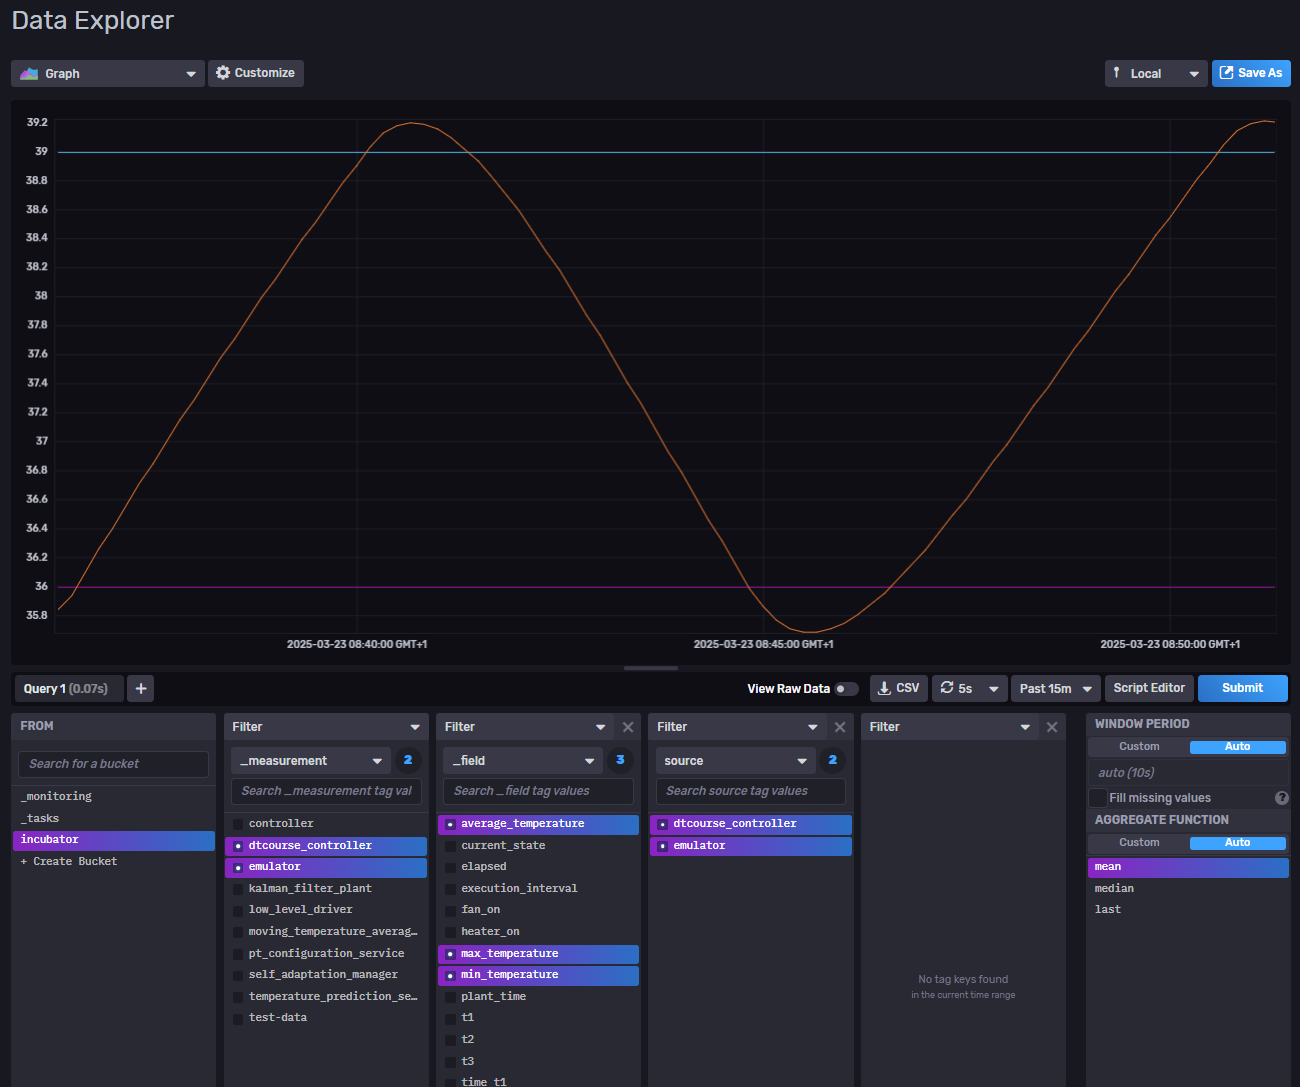


Now that the system is running, we will deploy the STL monitoring service below, following the same approach.

## Deploying the Monitor

The service below queries a batch of data from the past 1h in influxdb, and checks that the temperature drops below the max temperature always within 60 seconds of having exceeded it. This is not always the case, so we expect to see the robustness being negative sometimes.

In [ ]:
%%writefile stl_monitoring_service.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be 8-Monitoring
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '8-Monitoring', 'Current directory is not 8-Monitoring'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from incubator.communication.server.rabbitmq import Rabbitmq
from incubator.communication.shared.protocol import ROUTING_KEY_STATE

class STLMonitoringService:
    
    def __init__(self, rabbitmq_config, influxdb_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("STLMonitoringService")

        # Specification
        self._spec = rtamt.StlDenseTimeSpecification()
        # Declare the variables that will correspond to the above signals.
        self._spec.declare_var('T', 'float')
        self._spec.declare_var('max_T', 'float')
        self._spec.spec = 'always((T >= max_T) implies (eventually[0:60](T <= max_T)))'
        self._spec.parse()
        
    def setup(self):
        self._rabbitmq.connect_to_server()

        # Initialize the Query API
        self._query_api = self._client.query_api()
        self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

        # Subscribe to any message coming from the incubator physical twin.
        self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)

        self._l.info(f"STLMonitoringService setup complete.")

    def query_influxdb(self):
        # Define your Flux query: Query the relevant temperature data.
        # Feel free to adjust the start time, but leave the stop time as is.
        # We set a stop time of -3s to ensure that the data is aligned from the different measurements.
        flux_query = f'''
            from(bucket: "{self._bucket}")
            |> range(start: -1h, stop: -3s)
            |> filter(fn: (r) => r["_measurement"] == "emulator" or r["_measurement"] == "dtcourse_controller")
            |> filter(fn: (r) => r["_field"] == "average_temperature" or r["_field"] == "max_temperature" or r["_field"] == "min_temperature")
            |> filter(fn: (r) => r["source"] == "emulator" or r["source"] == "dtcourse_controller")
            |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
            |> yield(name: "last")
        '''
        # Execute the query
        result = self._query_api.query(org=self._org, query=flux_query)

        # From the query above, the data comes in 3 tables (one per measurement).
        # Importantly, the data is aligned on the time axis, so we should be able to just transfer the data to the right arrays for ramt.
        max_temperature = []
        temperature = []
    
        for table in result:
            self._l.debug("Table:")
            self._l.debug(table)
            for record in table.records:
                ts = record.get_time().timestamp()
                self._l.debug("Record at timestamp: " + str(ts))
                self._l.debug(record)
                if record.get_field() == 'max_temperature':
                    max_temperature.append([ts, record.get_value()])
                elif record.get_field() == 'average_temperature':
                    temperature.append([ts, record.get_value()])
        
        assert len(max_temperature) == len(temperature), 'Temperature and max_temperature data not aligned.'

        return temperature, max_temperature

    def compute_robustness(self, temperature, max_temperature):
        # Evaluate ramt on the signals and get the robustness.
        print("Evaluating ramt on the signals.")
        robustness = self._spec.evaluate(['T', temperature], ['max_T', max_temperature])
        return robustness

    def store_robustness(self, robustness):
        # Store the robustness in the influxdb. Duplicate records on the same timestamp will just be updated.
        records = []
        for r in robustness:
            ts = int(r[0] * 1e9)

            records.append({
                "measurement": "robustness",
                "tags": {
                    "source": "stl_monitor"
                },
                "time": ts,
                "fields": {
                    "robustness": r[1]
                }
                })

        self._write_api.write(bucket=self._bucket, record=records)

    def process_state_sample(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the temperature history from the influxdb, and process the temperature data into signals that ramt can understand.
        temperature, max_temperature = self.query_influxdb()

        self._l.debug(f"Temperature: {temperature}")
        self._l.debug(f"Max Temperature: {max_temperature}")

        # Evaluate ramt on the signals and get the robustness.
        robustness = self.compute_robustness(temperature, max_temperature)

        self._l.debug(f"Robustness: {robustness}")

        # Store the robustness in the influxdb.
        self.store_robustness(robustness)

    def start_serving(self):
        self._rabbitmq.start_consuming()
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from incubator.config.config import load_config
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    service = STLMonitoringService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the STLMonitoringService
    service.start_serving()

Running the above script from a terminal, and then opening the influxdb page, should give you the following results:

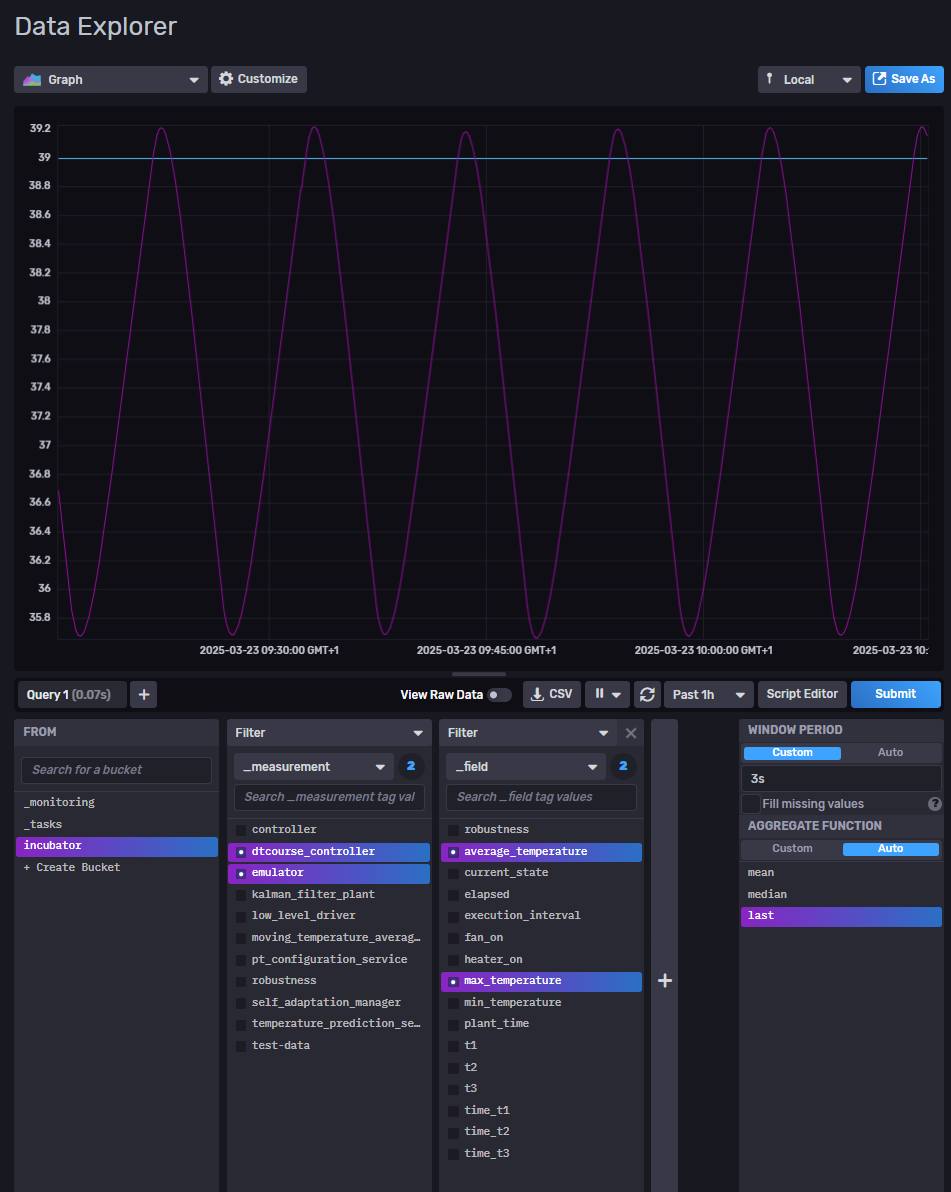

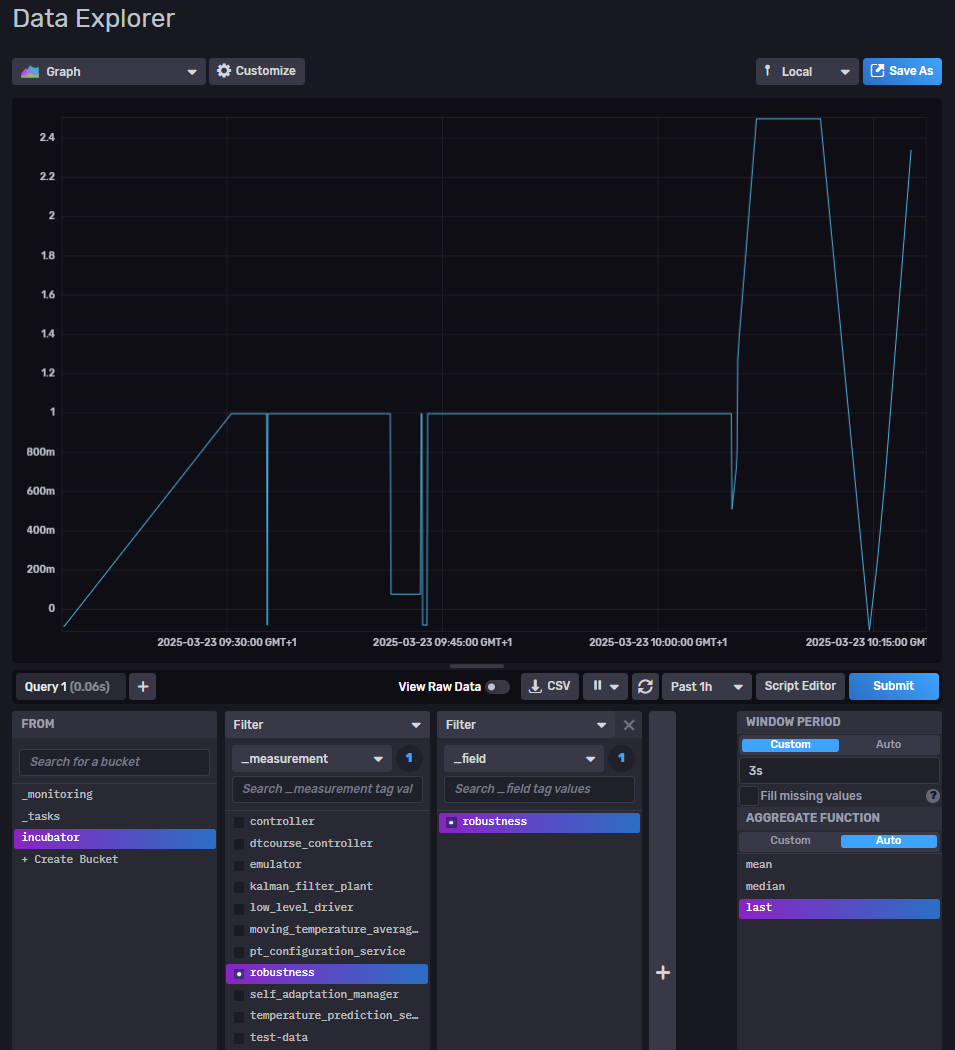

As can be seen, the robustness goes negative when the temperature takes longer to drop below the max temperature.

## Exercise

Can you try and write down some other useful STL properties for the incubator?

Try editing the STL monitoring service to use one of these properties and try to visualize the results.